In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [44]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset


    #train multiple classifiers
    for T in tasks:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        print('Training %s'%T)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
            test_index = test_index[task_inds]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)

            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
path = r'Y:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
dict_path = 'Y:\CIS-PD Study\Data_dict' #remote repo
# dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

scores_path = r'Y:\CIS-PD Study\Scores' #remote repo
# scores_path = '../Scores/' #local path

#path where feature matrix is saved
# features_path = '../FeatureMatrix' #local
features_path = 'Y:\CIS-PD Study\FeatureMatrix'

## Load unpacked features data

In [5]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
filename = 'Features_AllLocsHP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [6]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008648,0.010949,0.007293,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008127,0.010331,0.007008,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [7]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [8]:
# #drop features 
# Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
# Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

In [9]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [10]:
Dataorig = Data.copy()
Data.shape

(40377, 63)

In [11]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

## LOSO CV - ALL TASKS

## Bradykinesia

In [12]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [13]:
Dataorig = Data.copy()

In [ ]:
Dataorig[symptom].unique()

In [ ]:
Data[symptom].unique()

In [14]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/32368 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.534, rec=0.589, Spec=0.743, auroc_train=1.000, auroc=0.724

Subj/Visit 1, prec=0.952, rec=0.756, Spec=0.589, auroc_train=1.000, auroc=0.760

Subj/Visit 2, prec=0.758, rec=0.752, Spec=0.683, auroc_train=1.000, auroc=0.783

Subj/Visit 3, prec=0.467, rec=0.938, Spec=0.572, auroc_train=1.000, auroc=0.859

Subj/Visit 4, prec=0.781, rec=0.587, Spec=0.724, auroc_train=1.000, auroc=0.738

Subj/Visit 5, prec=0.606, rec=0.637, Spec=0.407, auroc_train=1.000, auroc=0.536

Subj/Visit 6, prec=0.647, rec=0.791, Spec=0.598, auroc_train=1.000, auroc=0.789

Subj/Visit 7, prec=0.871, rec=0.648, Spec=0.411, auroc_train=1.000, auroc=0.555

Subj/Visit 8, prec=0.298, rec=0.503, Spec=0.539, auroc_train=1.000, auroc=0.533

Subj/Visit 9, prec=0.655, rec=0.810, Spec=0.584, auroc_train=1.000, auroc=0.765

Subj/Visit 10, prec=0.567, rec=0.552, Spec=0.697, auroc_train=1.000, auroc=0.695

Subj/Visit 11, prec=0.265, rec=0.745, Spec=0.

In [ ]:
resultsbrady = res_group['Random Forest']['auroc']

In [ ]:
np.save('./Results/resultsbradyLOSO.npy',resultsbrady)

In [ ]:
np.unique(groups)

Removing nans

In [ ]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

{'Random Forest': {'auprc': [0.5889868534356698,
   0.9635170204372023,
   0.8054264987486712,
   0.6564021094426745,
   0.7926546898116112,
   0.6446784633785697,
   0.7627173534409345,
   0.872978602093048,
   0.28046675936305476,
   0.7238027447665378,
   0.6228208163267427,
   0.5143333728845634,
   0.5777332430729901,
   0.3313770811065859,
   0.8126097099356299,
   0.4880989996806381,
   0.8340497378780263,
   0.6536169843768844,
   0.9341467046850722],
  'auroc': [0.7237182286662591,
   0.7598365910751294,
   0.7827963317149723,
   0.8590266771116091,
   0.7380843018779522,
   0.5355027661610599,
   0.7891759369354949,
   0.5553518749040806,
   0.5330422219259942,
   0.7653426778152017,
   0.6951973023484732,
   0.8534194754425519,
   0.551969114437217,
   0.6977225672877847,
   0.7921197542717204,
   0.7670875906034408,
   0.8149234520339991,
   0.6877727802765284,
   0.6253039902103535],
  'f1': [0.56,
   0.8427961929766984,
   0.7549120992761117,
   0.6234607906675307,
   0.6

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


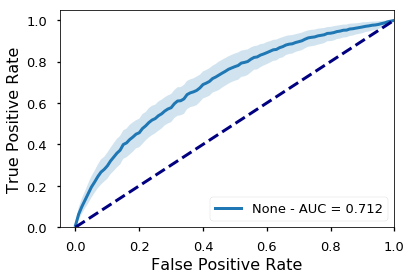

In [19]:
plot_roc(res_group['Random Forest']['tpr'],res_group['Random Forest']['fpr'][0],np.mean(res_group['Random Forest']['auroc']))

### Tremor

In [ ]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
resultstremor = res_group['Random Forest']['auroc']

In [ ]:
np.save('./Results/resultstremorLOSO.npy',resultstremor)

Removing nans

In [ ]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Personal Models

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


In [ ]:
resultsbrady_pers=res_all.auroc.values
np.save('./Results/resultsbradyPERS.npy',resultsbrady_pers)

In [ ]:
Data.shape

In [ ]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

In [ ]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1])

Is variability due to variability in symptoms between visits?

### Tremor

In [ ]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


In [ ]:
resultstremor_pers=res_all.auroc.values
np.save('./Results/resultstremorPERS.npy',resultstremor_pers)

In [ ]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

In [ ]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.])

## Box plots comparing global and personal

In [ ]:
resultstremor = np.load('./Results/resultstremorLOSO.npy')
resultsbrady = np.load('./Results/resultsbradyLOSO.npy')

In [ ]:
resultsbrady_pers=np.load('./Results/resultsbradyPERS.npy')
resultstremor_pers=np.load('./Results/resultstremorPERS.npy')

In [ ]:
len(resultstremor)

In [ ]:
results = pd.DataFrame({'Population-Bradykinesia':resultsbrady, 'Personal-Bradykinesia':resultsbrady_pers,
             'Population-Tremor':resultstremor, 'Personal-Tremor':resultstremor_pers})

In [ ]:
results[['Population-Bradykinesia','Personal-Bradykinesia']].plot(kind='box')

In [ ]:
results[['Population-Tremor','Personal-Tremor']].plot(kind='box')

In [ ]:
results.plot(kind='box')
plt.xticks(rotation=90)

## Evaluate performance of global models on Subtasks (this section has to be rewritten to train global and personal models on all tasks and analyze performance on each subset of tasks)

In [20]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]

Rows w Bradykinesia 16574/32368 = 0.51
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=0.558, rec=0.399, Spec=0.677, auroc_train=1.000, auroc=0.594

Subj/Visit 1, prec=0.624, rec=0.854, Spec=0.070, auroc_train=1.000, auroc=0.645

Subj/Visit 2, prec=0.769, rec=0.900, Spec=0.565, auroc_train=1.000, auroc=0.862

Subj/Visit 3, prec=0.676, rec=0.863, Spec=0.633, auroc_train=1.000, auroc=0.843

Subj/Visit 4, prec=0.967, rec=0.593, Spec=0.750, auroc_train=1.000, auroc=0.664

Subj/Visit 5, prec=0.373, rec=0.828, Spec=0.160, auroc_train=1.000, auroc=0.492

Subj/Visit 6, prec=0.812, rec=0.926, Spec=0.544, auroc_train=1.000, auroc=0.856
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.947, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.495, rec=0.591, Spec=0.309, auroc_train=1.000, auroc=0.411

Subj/Visit 9, prec=0.455, rec=1.000, Spec=0.284, auroc_train=1.000, auroc=0.741

Subj/Visit 10, prec=0.622, rec=0.782, Spec=0.549, auroc_train=1.000, auroc=0.760

Subj/Visit 11, prec=0.286, rec=0.435, Spec=0.771, auroc_train=1.000, auroc=0.670
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.876, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.703, rec=0.473, Spec=0.891, auroc_train=1.000, auroc=0.778

Subj/Visit 14, prec=0.723, rec=0.691, Spec=0.791, auroc_train=1.000, auroc=0.835

Subj/Visit 15, prec=0.203, rec=0.389, Spec=0.450, auroc_train=1.000, auroc=0.410

Subj/Visit 16, prec=0.744, rec=0.829, Spec=0.643, auroc_train=1.000, auroc=0.833

Subj/Visit 17, prec=0.827, rec=0.506, Spec=0.809, auroc_train=1.000, auroc=0.728
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.455, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.662+/-0.181, prec=0.676+/-0.232, rec=0.702+/-0.204, auprc=0.719+/-0.244, auroc=0.695+/-0.147
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.698, rec=0.718, Spec=0.867, auroc_train=1.000, auroc=0.809

Subj/Visit 1, prec=0.965, rec=0.913, Spec=0.000, auroc_train=1.000, auroc=0.455

Subj/Visit 2, prec=0.932, rec=1.000, Spec=0.927, auroc_train=1.000, auroc=0.985

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.423, rec=0.732, Spec=0.770, auroc_train=1.000, auroc=0.822

Subj/Visit 5, prec=0.462, rec=0.076, Spec=0.472, auroc_train=1.000, auroc=0.354

Subj/Visit 6, prec=0.920, rec=0.982, Spec=0.927, auroc_train=1.000, auroc=0.969

Subj/Visit 7, prec=0.562, rec=0.834, Spec=0.126, auroc_train=1.000, auroc=0.532

Subj/Visit 8, prec=0.686, rec=0.367, Spec=0.832, auroc_train=1.000, auroc=0.706

Subj/Visit 9, prec=0.885, rec=0.984, Spec=0.871, auroc_train=1.000, auroc=0.964
only 1 class in test data - cannot compute roc curve

Subj/Visit 10, prec=1.000, rec=0.512, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 11, prec=0.667, rec=0.962, Spec=0.900, auroc_train=1.000, auroc=0.988

Subj/Visit 12, prec=0.374, rec=0.243, Spec=0.686, auroc_train=1.000, auroc=0.379

Subj/Visit 13, prec=0.610, rec=0.419, Spec=0.922, auroc_train=1.000, auroc=0.825

Subj/Visit 14, prec=0.816, rec=0.614, Spec=0.934, auroc_train=1.000, auroc=0.803

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.948, auroc_train=1.000, auroc=0.547

Subj/Visit 16, prec=0.974, rec=0.709, Spec=0.982, auroc_train=1.000, auroc=0.923

Subj/Visit 17, prec=0.222, rec=0.042, Spec=0.972, auroc_train=1.000, auroc=0.721

Subj/Visit 18, prec=0.849, rec=0.336, Spec=0.871, auroc_train=1.000, auroc=0.603
f1_test=0.612+/-0.304, prec=0.686+/-0.279, rec=0.602+/-0.339, auprc=0.728+/-0.267, auroc=0.744+/-0.212
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.593, rec=0.598, Spec=0.853, auroc_train=1.000, auroc=0.780
only 1 class in test data - cannot compute roc curve

Subj/V

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 2, prec=0.781, rec=0.562, Spec=0.662, auroc_train=1.000, auroc=0.609

Subj/Visit 3, prec=0.259, rec=0.846, Spec=0.516, auroc_train=1.000, auroc=0.706

Subj/Visit 4, prec=0.688, rec=0.432, Spec=0.676, auroc_train=1.000, auroc=0.606

Subj/Visit 5, prec=0.426, rec=0.737, Spec=0.366, auroc_train=1.000, auroc=0.593

Subj/Visit 6, prec=0.335, rec=0.535, Spec=0.425, auroc_train=1.000, auroc=0.478
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.582, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.152, rec=0.364, Spec=0.619, auroc_train=1.000, auroc=0.496

Subj/Visit 9, prec=0.588, rec=0.660, Spec=0.609, auroc_train=1.000, auroc=0.681

Subj/Visit 10, prec=0.031, rec=0.182, Spec=0.853, auroc_train=1.000, auroc=0.640

Subj/Visit 11, prec=0.076, rec=0.714, Spec=0.674, auroc_train=1.000, auroc=0.824

Subj/Visit 12, prec=0.494, rec=0.425, Spec=0.565, auroc_train=1.000, auroc=0.484

Subj/Visit 13, prec=0.022, rec=0.364, Spec=0.612, auroc_train=1.000, auroc=0.486

Subj/Visit 14, prec=0.846, rec=0.557, Spec=0.799, auroc_train=1.000, auroc=0.780

Subj/Visit 15, prec=0.067, rec=0.692, Spec=0.655, auroc_train=1.000, auroc=0.755

Subj/Visit 16, prec=0.630, rec=0.617, Spec=0.706, auroc_train=1.000, auroc=0.709

Subj/Visit 17, prec=0.611, rec=0.562, Spec=0.276, auroc_train=1.000, auroc=0.415
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.413, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.460+/-0.228, prec=0.505+/-0.329, rec=0.55

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.433, rec=0.683, Spec=0.603, auroc_train=1.000, auroc=0.714

Subj/Visit 1, prec=1.000, rec=0.858, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 2, prec=0.636, rec=0.848, Spec=0.575, auroc_train=1.000, auroc=0.831

Subj/Visit 3, prec=0.362, rec=0.978, Spec=0.456, auroc_train=1.000, auroc=0.885

Subj/Visit 4, prec=0.902, rec=0.725, Spec=0.735, auroc_train=1.000, auroc=0.819

Subj/Visit 5, prec=0.916, rec=0.920, Spec=0.721, auroc_train=1.000, auroc=0.887

Subj/Visit 6, prec=0.734, rec=0.804, Spec=0.618, auroc_train=1.000, auroc=0.830

Subj/Visit 7, prec=0.852, rec=0.604, Spec=0.718, auroc_train=1.000, auroc=0.719

Subj/Visit 8, prec=0.246, rec=0.780, Spec=0.346, auroc_train=1.000, auroc=0.519

Subj/Visit 9, prec=0.667, rec=0.817, Spec=0.465, auroc_train=1.000, auroc=0.736

Subj/Visit 10, prec=0.337, rec=0.566, Spec=0.561, auroc_train=1.000, auroc=0.636

Subj/Visit 11, prec=0.227, rec=0.673, Spec=0.695, auroc_train=1.000, auroc=0.805

Subj/Visit 12, prec=0.552

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Rows w Tremor 8169/32330 = 0.25
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=0.830, rec=0.565, Spec=0.967, auroc_train=1.000, auroc=0.904

Subj/Visit 1, prec=0.743, rec=0.514, Spec=0.642, auroc_train=1.000, auroc=0.598

Subj/Visit 2, prec=0.980, rec=0.605, Spec=0.988, auroc_train=1.000, auroc=0.943

Subj/Visit 3, prec=0.531, rec=0.578, Spec=0.816, auroc_train=1.000, auroc=0.809

Subj/Visit 4, prec=0.895, rec=0.215, Spec=0.976, auroc_train=1.000, auroc=0.679

Subj/Visit 5, prec=0.657, rec=0.841, Spec=0.254, auroc_train=1.000, auroc=0.632

Subj/Visit 6, prec=0.978, rec=0.386, Spec=0.984, auroc_train=1.000, auroc=0.809

Subj/Visit 7, prec=0.867, rec=0.433, Spec=0.939, auroc_train=1.000, auroc=0.781

Subj/Visit 8, prec=0.793, rec=0.295, Spec=0.333, auroc_tr

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.926, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.071, rec=0.083, Spec=0.886, auroc_train=1.000, auroc=0.627

Subj/Visit 17, prec=1.000, rec=0.410, Spec=1.000, auroc_train=1.000, auroc=0.818

Subj/Visit 18, prec=1.000, rec=0.177, Spec=1.000, auroc_train=1.000, auroc=0.593
f1_test=0.416+/-0.252, prec=0.589+/-0.369, rec=0.359+/-0.235, auprc=0.607+/-0.316, auroc=0.719+/-0.151
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.884, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.993, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.980, auroc_train=1.000, auroc=0.296


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.379


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.210, Spec=1.000, auroc_train=1.000, auroc=0.964


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.606, rec=0.727, Spec=0.926, auroc_train=1.000, auroc=0.939


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=1.000, rec=0.014, Spec=1.000, auroc_train=1.000, auroc=0.871

Subj/Visit 18, prec=0.993, rec=0.603, Spec=0.987, auroc_train=1.000, auroc=0.793
f1_test=0.094+/-0.224, prec=0.189+/-0.375, rec=0.082+/-0.206, auprc=0.648+/-0.390, auroc=0.707+/-0.268
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.342, rec=0.188, Spec=0.926, auroc_train=1.000, auroc=0.630

Subj/Visit 1, prec=0.826, rec=0.057, Spec=0.923, auroc_train=1.000, auroc=0.463

Subj/Visit 2, prec=0.037, rec=0.013, Spec=0.954, auroc_train=1.000, auroc=0.523

Subj/Visit 3, prec=0.019, rec=0.042, Spec=0.923, auroc_train=1.000, auroc=0.536

Subj/Visit 4, prec=0.485, rec=0.117, Spec=0.928, auroc_train=1.000, auroc=0.569

Subj/Visit 5, prec=0.731, rec=0.393, Spec=0.794, auroc_train=1.000, auroc=0.654

Subj/Visit 6,

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.991, auroc_train=1.000, auroc=nan

Subj/Visit 8, prec=0.987, rec=0.240, Spec=0.986, auroc_train=1.000, auroc=0.708


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.926, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.939, auroc_train=1.000, auroc=0.510


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.768, rec=0.442, Spec=0.851, auroc_train=1.000, auroc=0.750


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.909, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.245, rec=0.165, Spec=0.922, auroc_train=1.000, auroc=0.645


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.981, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.968, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.852, rec=0.132, Spec=0.866, auroc_train=1.000, auroc=0.435

Subj/Visit 18, prec=0.830, rec=0.197, Spec=0.854, auroc_train=1.000, auroc=0.593
f1_test=0.147+/-0.180, prec=0.322+/-0.372, rec=0.104+/-0.133, auprc=0.466+/-0.349, auroc=0.569+/-0.104
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.182, rec=0.160, Spec=0.927, auroc_train=1.000, auroc=0.695

Subj/Visit 1, prec=0.833, rec=0.022, Spec=0.997, auroc_train=1.000, auroc=0.761

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.793


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.845, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.421, rec=0.038, Spec=0.971, auroc_train=1.000, auroc=0.691

Subj/Visit 5, prec=0.562, rec=0.173, Spec=0.898, auroc_train=1.000, auroc=0.603


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=nan

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=0.806

Subj/Visit 8, prec=0.984, rec=0.463, Spec=0.985, auroc_train=1.000, auroc=0.888


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.917, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.954, auroc_train=1.000, auroc=0.296


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.991, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.674, rec=0.709, Spec=0.718, auroc_train=1.000, auroc=0.763


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.967, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.158, rec=0.077, Spec=0.960, auroc_train=1.000, auroc=0.654


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.972, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.978, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.978, rec=0.264, Spec=0.983, auroc_train=1.000, auroc=0.723

Subj/Visit 18, prec=0.904, rec=0.316, Spec=0.936, auroc_train=1.000, auroc=0.758
f1_test=0.150+/-0.224, prec=0.300+/-0.379, rec=0.117+/-0.191, auprc=0.474+/-0.319, auroc=0.703+/-0.142
('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
('Motor #2: Walking', 'Motor #3: Walking while Counting')


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Elapsed time = 22.209 min


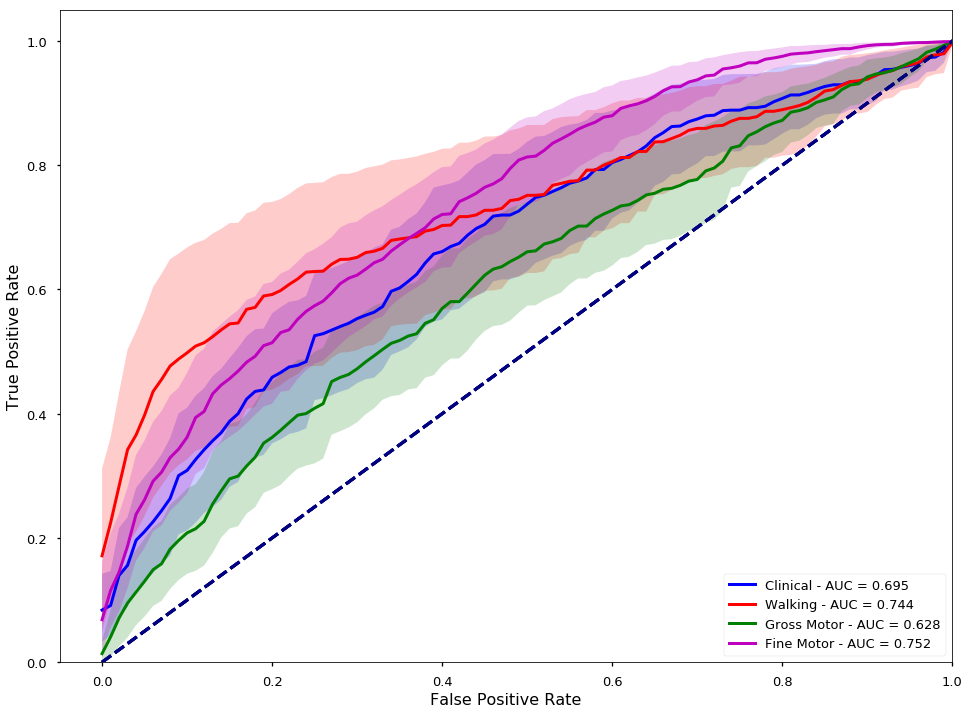

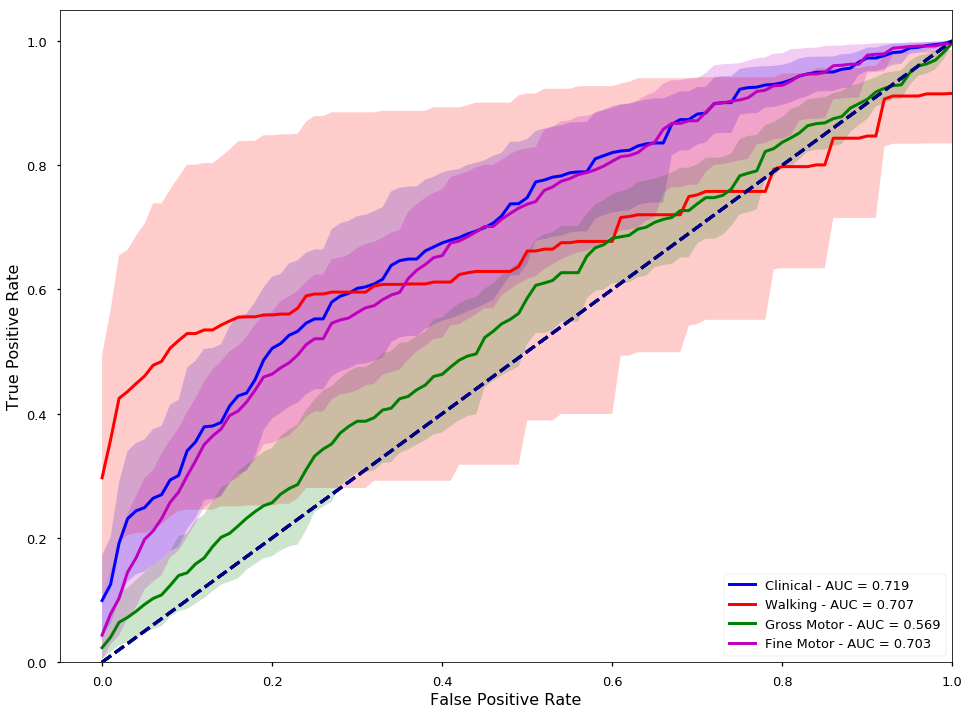

In [98]:
# Global Models
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia', 'Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV_Tasks(Data,X,y,groups,tasks,models[0][0])
    res_all = pd.concat((res_all,res))
    
    Tasks = list(res_group.keys())
    AX=None
    plt.figure(figsize=(16,12))
    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor']
    for x,T in zip(range(len(Tasks)),Tasks):
        print(T)
        NanInds = []
        for i in range(len(res_group[T]['auroc'])):
            if np.isnan(res_group[T]['auroc'][i]):
                NanInds.append(i)
        for i in sorted(NanInds,reverse=True):
            del res_group[T]['tpr'][i]
            del res_group[T]['auroc'][i]
        if AX==None:
            AX = plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],ax=AX,col=cols[x])

    plt.savefig(symptom+'Tasks.svg')
    plt.savefig(symptom+'Tasks.png')
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

Rows w Bradykinesia 16574/32368 = 0.51
Subject 1004
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.800, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.657, auroc_train=1.000, auroc=0.613

Subj/Visit 2, prec=0.643, rec=0.750, Spec=0.853, auroc_train=1.000, auroc=0.886

Subj/Visit 3, prec=0.645, rec=0.800, Spec=0.560, auroc_train=1.000, auroc=0.694

Subj/Visit 4, prec=0.529, rec=0.692, Spec=0.784, auroc_train=1.000, auroc=0.835

Subj/Visit 5, prec=0.875, rec=0.583, Spec=0.917, auroc_train=1.000, auroc=0.817
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.522, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.612+/-0.262, prec=0.670+/-0.323, rec=0.592+/-0.261, auprc=0.734+/-0.237, auroc=0.769+/-0.100
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.548, rec=0.425, Spec=0.000, auroc_train=1.000, auroc=0.168


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.613


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.781, rec=1.000, Spec=0.720, auroc_train=1.000, auroc=0.898


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.667, rec=0.960, Spec=0.520, auroc_train=1.000, auroc=0.810
f1_test=0.306+/-0.371, prec=0.285+/-0.335, rec=0.341+/-0.429, auprc=0.676+/-0.107, auroc=0.622+/-0.282
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.081, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.929, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.250, rec=0.200, Spec=0.850, auroc_train=1.000, auroc=0.557


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.600, rec=0.545, Spec=0.915, auroc_train=1.000, auroc=0.828
f1_test=0.135+/-0.197, prec=0.264+/-0.365, rec=0.118+/-0.188, auprc=0.611+/-0.318, auroc=0.693+/-0.135
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.030, Spec=1.000, auroc_train=1.000, auroc=0.773

Subj/Visit 1, prec=0.700, rec=0.636, Spec=0.951, auroc_train=1.000, auroc=0.931

Subj/Visit 2, prec=0.562, rec=0.750, Spec=0.891, auroc_train=1.000, auroc=0.927

Subj/Visit 3, prec=0.571, rec=0.444, Spec=0.830, auroc_train=1.000, auroc=0.762

Subj/Visit 4, prec=0.417, rec=0.769, Spec=0.770, auroc_train=1.000, auroc=0.851

Subj/Visit 5, prec=0.636, rec=0.318, Spec=0.917, auroc_train=1.000, auroc=0.766

Subj/Visit 6, prec=0.059, rec=0.067, Spec=0.775, auroc_train=1.000, auroc=0.592
f1_test=0.414+/

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.353, rec=1.000, Spec=0.389, auroc_train=1.000, auroc=0.981

Subj/Visit 2, prec=0.385, rec=1.000, Spec=0.529, auroc_train=1.000, auroc=0.988
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=0.800, rec=1.000, Spec=0.700, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.444, rec=0.800, Spec=0.167, auroc_train=1.000, auroc=0.688
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.692+/-0.151, prec=0.712+/-0.284, rec=0.817+/-0.199, auprc=0.952+/-0.084, auroc=0.914+/-0.131
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=0.760, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.434
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.981+/-0.048, prec=0.966+/-0.084, rec=1.000+/-0.000, auprc=0.979+/-0.052, auroc=0.434+/-0.000
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.971, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=0.982, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.991, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.977, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.981, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.993+/-0.005, prec=1.000+/-0.000, rec=0.986+/-0.010, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.957, rec=1.000, Spec=0.786, auroc_train=1.000, auroc=0.992

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.985, rec=1.000, Spec=0.923, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.935, rec=1.000, Spec=0.643, auroc_train=1.000, auroc=0.998

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.991+/-0.013, prec=0.982+/-0.024, rec=1.000+/-0.000, auprc=1.000+/-0.001, auroc=0.999+/-0.003
Subject 1018
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.542, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.889, rec=1.000, Spec=0.875, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.455, rec=1.000, Spec=0.647, auroc_train=1.000, auroc=0.835

Subj/Visit 3, prec=0.867, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.857, rec=1.000, Spec=0.833, auroc_train=1.000, auroc=0.955
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.538, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.832+/-0.139, prec=0.867+/-0.179, rec=0.869+/-0.208, auprc=0.920+/-0.174, auroc=0.958+/-0.064
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.963, rec=0.963, Spec=0.963, auroc_train=1.000, auroc=0.996

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.923, rec=1.000, Spec=0.917, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.989+/-0.017, prec=0.984+/-0.028, rec=0.995+/-0.013, auprc=0.999+/-0.001, auroc=0.999+/-0.001
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.969, rec=0.733, Spec=0.800, auroc_train=1.000, auroc=0.813

Subj/Visit 1, prec=0.732, rec=0.881, Spec=0.387, auroc_train=1.000, auroc=0.635

Subj/Visit 2, prec=0.750, rec=0.840, Spec=0.462, auroc_train=1.000,

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.939, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.500, rec=0.024, Spec=0.985, auroc_train=1.000, auroc=0.850

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=0.771


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.938, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.980, auroc_train=1.000, auroc=nan
f1_test=0.021+/-0.036, prec=0.214+/-0.364, rec=0.011+/-0.019, auprc=0.600+/-0.186, auroc=0.811+/-0.032
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.769, auroc_train=1.000, auroc=0.422

Subj/Visit 1, prec=1.000, rec=0.536, Spec=1.000, auroc_train=1.000, auroc=0.993


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.762, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.500, rec=0.692, Spec=0.857, auroc_train=1.000, auroc=0.896

Subj/Visit 4, prec=1.000, rec=0.296, Spec=1.000, auroc_train=1.000, auroc=0.991

Subj/Visit 5, prec=1.000, rec=0.400, Spec=1.000, auroc_train=1.000, auroc=0.996

Subj/Visit 6, prec=1.000, rec=0.345, Spec=1.000, auroc_train=1.000, auroc=0.961
f1_test=0.403+/-0.264, prec=0.643+/-0.440, rec=0.324+/-0.238, auprc=0.751+/-0.327, auroc=0.876+/-0.206
Subject 1024
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.923, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.909, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 6, prec=0.455, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.571
f1_test=0.934+/-0.128, prec=0.922+/-0.191, rec=0.976+/-0.038, auprc=0.938+/-0.152, auroc=0.571+/-0.000
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.033, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.812, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.938, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.978, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.958, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=1.000, rec=0.346, Spec=1.000, auroc_train=1.000, auroc=0.963
f1_test=0.083+/-0.178, prec=0.286+/-0.452, rec=0.054+/-0.120, auprc=0.982+/-0.018, auroc=0.963+/-0.000
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.657, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.407, rec=1.000, Spec=0.435, auroc_train=1.000, auroc=0.964

Subj/Visit 2, prec=0.333, rec=1.000, Spec=0.333, auroc_train=1.000, auroc=0.847
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.577, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=0.800, rec=0.750, Spec=0.750, auroc_train=1.000, auroc=0.855

Subj/Visit 5, prec=0.900, rec=0.804, Spec=0.868, auroc_train=1.000, auroc=0.904

Subj/Visit 6, prec=0.205, rec=0.810, Spec=0.224, auroc_train=1.000, auroc=0.564
f1_test=0.650+/-0.175, prec=0.664+/-0.313, rec=0.800+/-0.148, auprc=0.786+/-0.265, auroc=0.827+/-0.138
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.976, rec=0.847, Spec=0.900, auroc_train=1.000, auroc=0.966

Subj/Visit 1, prec=1.000, rec=0.955, Spec=1.000, auroc_train=1.000, auroc=0.991

Subj/Visit 2, prec=0.783, rec=1.000, Spec=0.423, auroc_train=1.000, auroc=0.963

Subj/Visit 3, prec=0.983, rec=0.894, Spec=0.929, auroc_train=1.000, auroc=0.985

Subj/Visit 4, prec=0.825, rec=0.800, Spec=0.154, auroc_train=1.000, auroc=0.725

Subj/Visit 5, prec=0.662, rec=0.804, Spec=0.115, auroc_train=1.000, auroc=0.549

Subj/Visit 6, prec=0.825, rec=1.000, Spec=0.542, auroc_train=1.00

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.500, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.900, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.857, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.778+/-0.334, prec=0.786+/-0.364, rec=0.799+/-0.333, auprc=0.891+/-0.236, auroc=0.961+/-0.080
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.926, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 3, prec=0.500, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.255
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.942, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 6, prec=0.500, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.527
f1_test=0.895+/-0.145, prec=0.857+/-0.226, rec=0.981+/-0.030, auprc=0.857+/-0.227, auroc=0.391+/-0.136
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.202, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.708, auroc_train=1.000, auroc=nan

Subj/Visit 2, prec=0.111, rec=0.179, Spec=0.615, auroc_train=1.000, auroc=0.394

Subj/Visit 3, prec=0.200, rec=0.273, Spec=0.745, auroc_train=1.000, auroc=0.485


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.613, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.693, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.324, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.170+/-0.178, prec=0.330+/-0.429, rec=0.140+/-0.128, auprc=0.585+/-0.415, auroc=0.440+/-0.046
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=1.000, rec=0.792, Spec=1.000, auroc_train=1.000, auroc=0.987

Subj/Visit 1, prec=0.982, rec=0.964, Spec=0.958, auroc_train=1.000, auroc=0.998

Subj/Visit 2, prec=0.817, rec=0.967, Spec=0.536, auroc_train=1.000, auroc=0.893

Subj/Visit 3, prec=1.000, rec=0.746, Spec=1.000, auroc_train=1.000, auroc=0.980

Subj/Visit 4, prec=0.930, rec=0.971, Spec=0.808, auroc_train=1.000, auroc=0.965

Subj/Visit 5, prec=0.941, rec=0.970, Spec=0.833, auroc_train=1.000, auroc=0.957

Subj/Visit 6, prec=0.983, rec=0.879, Spec=0.917, auroc_train=1.000, auroc=0.989
f1_test=0.919+/-0.041, prec=0.950+/-0.060, rec=0.898+/-0.088, auprc=0.986+/-0.018, auroc=0.967+/-0.033
Subject 1030
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=1.000, rec=0.950, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=1.000+/-0.000, prec=1.000+/-0.000, rec=1.000+/-0.000, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.471, rec=1.000, Spec=0.609, auroc_train=1.000, auroc=0.871

Subj/Visit 2, prec=0.328, rec=1.000, Spec=0.180, auroc_train=1.000, auroc=0.936

Subj/Visit 3, prec=0.903, rec=1.000, Spec=0.893, auroc_train=1.000, auroc=0.986

Subj/Visit 4, prec=0.917, rec=0.957, Spec=0.913, auroc_train=1.000, auroc=0.994

Subj/Visit 5, prec=0.800, rec=1.000, Spec=0.750, auroc_train=1.000, auroc=0.983
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.344, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.774+/-0.202, prec=0.774+/-0.248, rec=0.900+/-0.228, auprc=0.931+/-0.108, auroc=0.954+/-0.046
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.983, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.993, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.941, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.982, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.993+/-0.010, prec=1.000+/-0.000, rec=0.986+/-0.020, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.896, rec=0.986, Spec=0.429, auroc_train=1.000, auroc=0.825

Subj/Visit 1, prec=0.959, rec=0.986, Spec=0.786, auroc_train=1.000, auroc=0.967

Subj/Visit 2, prec=0.864, rec=0.987, Spec=0.294, auroc_train=1.000, auroc=0.738

Subj/Visit 3, prec=0.971, rec=0.957, Spec=0.800, auroc_train=1.000, auroc=0.982

Subj/Visit 4, prec=0.881, rec=0.881, Spec=0.385, auroc_train=1.000, auroc=0.798

Subj/Visit 5, prec=0.737, rec=1.000, Spec=0.333, auroc_train=1.000, auroc=0.728

Subj/Visit 6, prec=0.293, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.687
f1_test=0.854+/-0.169, prec=0.800+/-0.219, rec=0.971+/-0.039, auprc=0.868+/-0.167, auroc=0.818+/-0.108
Subject 1038
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.333, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.538, Spec=1.000, auroc_train=1.000, auroc=0.976

Subj/Visit 2, prec=1.000, rec=0.692, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.788

Subj/Visit 4, prec=0.500, rec=0.857, Spec=0.684, auroc_train=1.000, auroc=0.729

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.643, rec=0.750, Spec=0.583, auroc_train=1.000, auroc=0.764
f1_test=0.735+/-0.147, prec=0.830+/-0.202, rec=0.739+/-0.226, auprc=0.839+/-0.221, auroc=0.876+/-0.117
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=1.000, rec=0.966, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=0.962, rec=0.833, Spec=0.967, auroc_train=1.000, auroc=0.967

Subj/Visit 2, prec=0.947, rec=0.643, Spec=0.964, auroc_train=1.000, auroc=0.939

Subj/Visit 3, prec=1.000, rec=0.750, Spec=1.000, auroc_train=1.000, auroc=0.956

Subj/Visit 4, prec=

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.622


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.566

Subj/Visit 6, prec=1.000, rec=0.024, Spec=1.000, auroc_train=1.000, auroc=0.680
f1_test=0.007+/-0.017, prec=0.143+/-0.350, rec=0.003+/-0.009, auprc=0.451+/-0.072, auroc=0.622+/-0.046
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=0.704

Subj/Visit 1, prec=0.929, rec=0.765, Spec=0.986, auroc_train=1.000, auroc=0.966

Subj/Visit 2, prec=1.000, rec=0.419, Spec=1.000, auroc_train=1.000, auroc=0.854

Subj/Visit 3, prec=1.000, rec=0.692, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 4, prec=0.667, rec=0.286, Spec=0.973, auroc_train=1.000, auroc=0.895

Subj/Visit 5, prec=0.923, rec=0.857, Spec=0.985, auroc_train=1.000, auroc=0.989

Subj/Visit 6, prec=0.077, rec=0.040, Spec=0.782, auroc_train=1.000, auroc=0.353
f1_test=0.513+/-0.345, prec=0.656+/-0.405, rec=0.437+/-0.321, aupr

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.750, auroc_train=1.000, auroc=nan

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.571, Spec=1.000, auroc_train=1.000, auroc=0.977

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.800, rec=0.667, Spec=0.938, auroc_train=1.000, auroc=0.969

Subj/Visit 6, prec=1.000, rec=0.400, Spec=1.000, auroc_train=1.000, auroc=0.850
f1_test=0.653+/-0.315, prec=0.771+/-0.345, rec=0.591+/-0.324, auprc=0.934+/-0.082, auroc=0.922+/-0.098
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.966, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, 

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.804, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.963, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.959, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.979+/-0.037, prec=1.000+/-0.000, rec=0.961+/-0.066, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.981, auroc_train=1.000, auroc=0.395
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.133+/-0.000, auroc=0.395+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.812, rec=0.433, Spec=0.952, auroc_train=1.000, auroc=0.885

Subj/Visit 1, prec=0.400, rec=0.571, Spec=0.824, auroc_train=1.000, auroc=0.873

Subj/Visit 2, prec=0.500, rec=0.786, Spec=0.823, auroc_train=1.000, auroc=0.898

Subj/Visit 3, prec=0.700, rec=0.538, Spec=0.880, auroc_train=1.000, auroc=0.868

Subj/Visit 4, prec=1.000, rec=0.541, Spec=1.000, auroc_train=1.000, auroc=0.931

Subj/Visit 5, prec=0.130, rec=0.120, Spec=0.661, auroc_train=1.000, auroc=0.556

Subj/Visit 6, prec=0.550, rec=0.846, Spec=0.862, auroc_train=1.000, auroc=0.909
f1_test=0.536+/

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.364, Spec=1.000, auroc_train=1.000, auroc=0.967
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.200+/-0.285, prec=0.333+/-0.471, rec=0.144+/-0.207, auprc=0.985+/-0.015, auroc=0.983+/-0.017
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=1.000, rec=0.920, Spec=1.000, auroc_train=1.000, auroc=1.000


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.889, Spec=1.000, auroc_train=1.000, auroc=0.964
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.317+/-0.448, prec=0.333+/-0.471, rec=0.301+/-0.426, auprc=0.988+/-0.012, auroc=0.982+/-0.018
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.852


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.968, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall 

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being s

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.513+/-0.000, auroc=0.852+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.830, auroc_train=1.000, auroc=0.670


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\l

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.040, Spec=1.000, auroc_train=1.000, auroc=0.757
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\l

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=nan
f1_test=0.013+/-0.029, prec=0.167+/-0.373, rec=0.007+/-0.015, auprc=0.474+/-0.080, auroc=0.714+/-0.043
Subject 1049
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.885, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.893, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.875, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.958, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.923, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.846, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.953+/-0.027, prec=1.000+/-0.000, rec=0.911+/-0.049, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.933, rec=0.966, Spec=0.931, auroc_train=1.000, auroc=0.997

Subj/Visit 1, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.962, rec=0.893, Spec=0.964, auroc_train=1.000, auroc=0.989

Subj/Visit 3, prec=0.963, rec=0.929, Spec=0.964, auroc_train=1.000, auroc=0.979

Subj/Visit 4, prec=0.886, rec=0.975, Spec=0.875, auroc_train=1.000, auroc=0.976

Subj/Visit 5, prec=0.960, rec=0.857, Spec=0.964, auroc_train=1.000, auroc=0.983


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.481, auroc_train=1.000, auroc=nan
f1_test=0.795+/-0.325, prec=0.815+/-0.334, rec=0.779+/-0.322, auprc=0.988+/-0.008, auroc=0.987+/-0.009
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.768, rec=0.875, Spec=0.736, auroc_train=1.000, auroc=0.892

Subj/Visit 1, prec=0.889, rec=0.941, Spec=0.882, auroc_train=1.000, auroc=0.959

Subj/Visit 2, prec=0.828, rec=0.898, Spec=0.814, auroc_train=1.000, auroc=0.928

Subj/Visit 3, prec=0.837, rec=0.643, Spec=0.875, auroc_train=1.000, auroc=0.895

Subj/Visit 4, prec=0.865, rec=0.833, Spec=0.870, auroc_train=1.000, auroc=0.912

Subj/Visit 5, prec=0.712, rec=0.725, Spec=0.706, auroc_train=1.000, auroc=0.805

Subj/Visit 6, prec=0.450, rec=0.491, Spec=0.400, auroc_train=1.000, auroc=0.374
f1_test=0.766+/-0.138, prec=0.764+/-0.140, rec=0.772+/-0.150, auprc=0.824+/-0.174, auroc=0.824+/-0

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.951


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.963, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.932


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.885, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.809
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.842+/-0.094, auroc=0.897+/-0.063
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.513


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.156+/-0.000, auroc=0.513+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.835

Subj/Visit 1, prec=0.333, rec=0.077, Spec=0.969, auroc_train=1.000, auroc=0.897


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.974, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.257, Spec=1.000, auroc_train=1.000, auroc=0.850


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.966, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.667, rec=0.308, Spec=0.969, auroc_train=1.000, auroc=0.922

Subj/Visit 6, prec=0.667, rec=0.143, Spec=0.985, auroc_train=1.000, auroc=0.819
f1_test=0.170+/-0.175, prec=0.381+/-0.375, rec=0.112+/-0.119, auprc=0.636+/-0.096, auroc=0.865+/-0.039
Subject 1052
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=0.933, rec=1.000, Spec=0.929, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.909, rec=1.000, Spec=0.917, auroc_train=1.000, auroc=0.971

Subj/Visit 4, prec=1.000, rec=0.643, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.750, auroc_train=1.000, auroc=0.913
f1_test=0.887+/-0.121, pre

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.942, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.741, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.902, rec=1.000, Spec=0.636, auroc_train=1.000, auroc=0.995

Subj/Visit 4, prec=1.000, rec=0.200, Spec=1.000, auroc_train=1.000, auroc=0.805


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.374+/-0.428, prec=0.472+/-0.473, rec=0.367+/-0.453, auprc=0.947+/-0.073, auroc=0.932+/-0.090
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.820, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.603, rec=0.940, Spec=0.426, auroc_train=1.000, auroc=0.860

Subj/Visit 2, prec=0.625, rec=0.972, Spec=0.580, auroc_train=1.000, auroc=0.960

Subj/Visit 3, prec=0.851, rec=0.930, Spec=0.222, auroc_train=1.000, auroc=0.618

Subj/Visit 4, prec=0.633, rec=0.756, Spec=0.617, auroc_train=1.000, auroc=0.668

Subj/Visit 5, prec=1.000, rec=0.767, Spec=1.000, auroc_train=1.000, auroc=0.985
f1_test=0.807+/-0.082, prec=0.785+/-0.173, rec=0.864+/-0.087, auprc=0.867+/-0.157, auroc=0.818+/-0.150
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.926, Spec=1.000, auroc_train=1.000, auroc=0.999

Subj/Visit 1, prec=0.925, rec=0.942, Spec=0.846, auroc_train=1.000, auroc=0.989

Subj/Visit 2, prec=0.959, rec=0.940, Spec=0.923, auroc_train=1.000, auroc=0.973

Subj/Visit 3, prec=0.980, rec=0.960, Spec=0.962, auroc_train=1.000, auroc=0.994

Subj/Visit 4, prec=0.448, rec=1.000, Spec=0.407, auroc_train=1.00

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=0.907


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\l

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.750, auroc_train=1.000, auroc=nan
f1_test=0.159+/-0.250, prec=0.333+/-0.471, rec=0.111+/-0.184, auprc=0.971+/-0.004, auroc=0.903+/-0.005
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.404
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\l

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.962, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.179+/-0.000, auroc=0.404+/-0.000
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.667, rec=0.154, Spec=0.986, auroc_train=1.000, auroc=0.816
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.967, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall 

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.042+/-0.093, prec=0.111+/-0.248, rec=0.026+/-0.057, auprc=0.398+/-0.000, auroc=0.816+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.333, rec=0.111, Spec=0.500, auroc_train=1.000, auroc=0.491

Subj/Visit 1, prec=0.345, rec=0.833, Spec=0.712, auroc_train=1.000, auroc=0.910

Subj/Visit 2, prec=0.400, rec=0.833, Spec=0.773, auroc_train=1.000, auroc=0.927

Subj/Visit 3, prec=1.000, rec=0.333, Spec=1.000, auroc_train=1.000, auroc=0.905

Subj/Visit 4, prec=0.520, rec=1.000, Spec=0.815, auroc_train=1.000, auroc=0.956

Subj/Visit 5, prec=0.810, rec=0.436, Spec=0.911, auroc_train=1.000, auroc=0.750
f1_test=0.491+/-0.159, prec=0.568+/-0.252, rec=0.591+/-0.318, auprc=0.784+/-0.107, auroc=0.823+/-0.162
Subject 1054
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating 

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.800, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.750, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.600, rec=0.400, Spec=0.200, auroc_train=1.000, auroc=0.233

Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.667, auroc_train=1.000, auroc=0.973
f1_test=0.762+/-0.150, prec=0.850+/-0.214, rec=0.735+/-0.186, auprc=0.919+/-0.147, auroc=0.841+/-0.304
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.827, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.620
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.750, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=0.750, rec=0.111, Spec=0.963, auroc_train=1.000, auroc=0.606


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.815, auroc_train=1.000, auroc=nan
f1_test=0.342+/-0.423, prec=0.458+/-0.466, rec=0.310+/-0.408, auprc=0.733+/-0.297, auroc=0.613+/-0.007
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.682, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.625, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.742, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.170, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.821, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Cont

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.625, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.300, prec=0.333+/-0.471, rec=0.142+/-0.250, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.836, Spec=1.000, auroc_train=1.000, auroc=0.965

Subj/Visit 1, prec=0.750, rec=0.975, Spec=0.658, auroc_train=1.000, auroc=0.947

Subj/Visit 2, prec=0.778, rec=0.972, Spec=0.773, auroc_train=1.000, auroc=0.919

Subj/Visit 3, prec=0.920, rec=0.548, Spec=0.750, auroc_train=1.000, auroc=0.706

Subj/Visit 4, prec=0.841, rec=0.949, Spec=0.829, auroc_train=1.000, auroc=0.957

Subj/Visit 5, prec=0.878, rec=1.000, Spec=0.875, auroc_train=1.000, auroc=1.000
f1_test=0.856+/-0.081, prec=0.861+/-0.084, rec=0.880+/-0.158, auprc=0.946+/-0.048, auroc=0.916+/-0.097
Subject 1055
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 1, prec=0.333, rec=1.000, Spec=0.333, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.750, rec=0.500, Spec=0.800, auroc_train=1.000, auroc=0.571

Subj/Visit 3, prec=0.727, rec=0.889, Spec=0.000, auroc_train=1.000, auroc=0.361
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.333, rec=1.000, Spec=0.250, auroc_train=1.000, auroc=0.979
f1_test=0.622+/-0.105, prec=0.691+/-0.274, rec=0.731+/-0.234, auprc=0.915+/-0.106, auroc=0.728+/-0.272
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=1.000, rec=0.040, Spec=1.000, auroc_train=1.000, auroc=0.426


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.833, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.043, Spec=1.000, auroc_train=1.000, auroc=0.517


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being s

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.980, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.980, auroc_train=1.000, auroc=nan
f1_test=0.027+/-0.038, prec=0.333+/-0.471, rec=0.014+/-0.020, auprc=0.534+/-0.048, auroc=0.472+/-0.045
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.848, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 1, prec=0.574, rec=0.975, Spec=0.310, auroc_train=1.000, auroc=0.846

Subj/Visit 2, prec=0.400, rec=1.000, Spec=0.135, auroc_train=1.000, auroc=0.799

Subj/Visit 3, prec=0.790, rec=0.845, Spec=0.350, auroc_train=1.000, auroc=0.600
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.588, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.549, rec=0.824, Spec=0.395, auroc_train=1.000, auroc=0.671
f1_test=0.738+/-0.110, prec=0.719+/-0.229, rec=0.847+/-0.134, auprc=0.838+/-0.128, auroc=0.729+/-0.098
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.950, rec=0.891, Spec=0.750, auroc_train=1.000, auroc=0.939


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.408, auroc_train=1.000, auroc=nan

Subj/Visit 2, prec=0.214, rec=0.429, Spec=0.593, auroc_train=1.000, auroc=0.598

Subj/Visit 3, prec=1.000, rec=0.569, Spec=1.000, auroc_train=1.000, auroc=0.985

Subj/Visit 4, prec=1.000, rec=0.492, Spec=1.000, auroc_train=1.000, auroc=0.984

Subj/Visit 5, prec=0.421, rec=0.923, Spec=0.340, auroc_train=1.000, auroc=0.558
f1_test=0.528+/-0.303, prec=0.598+/-0.405, rec=0.551+/-0.310, auprc=0.707+/-0.354, auroc=0.813+/-0.193
Subject 1056
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=1.000+/-0.000, prec=1.000+/-0.000, rec=1.000+/-0.000, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.289, rec=1.000, Spec=0.135, auroc_train=1.000, auroc=0.563

Subj/Visit 1, prec=0.531, rec=0.963, Spec=0.148, auroc_train=1.000, auroc=0.649

Subj/Visit 2, prec=0.421, rec=0.640, Spec=0.120, auroc_train=1.000, auroc=0.491

Subj/Visit 3, prec=0.792, rec=1.000, Spec=0.167, auroc_train=1.000, auroc=0.859
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.983, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.753+/-0.221, prec=0.672+/-0.277, rec=0.931+/-0.131, auprc=0.733+/-0.272, auroc=0.640+/-0.138
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.993, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.999+/-0.001, prec=1.000+/-0.000, rec=0.999+/-0.003, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.871, rec=1.000, Spec=0.214, auroc_train=1.000, auroc=0.894

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.974, rec=0.962, Spec=0.857, auroc_train=1.000, auroc=0.981

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.969, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.907
f1_test=0.980+/-0.025, prec=0.969+/-0.046, rec=0.994+/-0.014, auprc=0.990+/-0.013, auroc=0.957+/-0.046
('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
('Motor #2: Walking', 'Motor #3: Walking while Counting')


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Rows w Tremor 8169/32330 = 0.25
Subject 1004
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.100, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.846, Spec=1.000, auroc_train=1.000, auroc=0.994


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.714, rec=0.833, Spec=0.882, auroc_train=1.000, auroc=0.873
f1_test=0.267+/-0.372, prec=0.388+/-0.456, rec=0.254+/-0.372, auprc=0.905+/-0.124, auroc=0.933+/-0.061
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.432


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave


Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.579
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.409+/-0.195, auroc=0.506+/-0.074
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.521


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.975, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.598+/-0.000, auroc=0.521+/-0.000
Subject 1016
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=0.227, rec=0.833, Spec=0.056, auroc_train=1.000, auroc=0.407
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=0.875, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.773, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 3, prec=0.789, rec=0.938, Spec=0.333, auroc_train=1.000, auroc=0.745

Subj/Visit 4, prec=0.800, rec=0.941, Spec=0.200, auroc_train=1.000, auroc=0.824
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.727, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.000, auroc_train=1.000, auroc=nan
f1_test=0.675+/-0.329, prec=0.688+/-0.378, rec=0.727+/-0.306, auprc=0.857+/-0.238, auroc=0.659+/-0.180
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.946, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.857, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.940, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.867, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.816, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.865, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Cont

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.833, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.933, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=0.902, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.868, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.927, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.923, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.946, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nsha

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.019, auroc_train=1.000, auroc=nan
f1_test=0.820+/-0.335, prec=0.857+/-0.350, rec=0.786+/-0.322, auprc=1.000+/-0.000, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.900, rec=0.947, Spec=0.905, auroc_train=1.000, auroc=0.989

Subj/Visit 1, prec=0.947, rec=1.000, Spec=0.947, auroc_train=1.000, auroc=0.997

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.974, rec=0.927, Spec=0.974, auroc_train=1.000, auroc=0.997

Subj/Visit 4, prec=0.955, rec=1.000, Spec=0.955, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.950, rec=1.000, Spec=0.947, auroc_train=1.000, auroc=1.000


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.475, auroc_train=1.000, auroc=nan
f1_test=0.828+/-0.339, prec=0.818+/-0.335, rec=0.839+/-0.344, auprc=0.997+/-0.004, auroc=0.997+/-0.004
Subject 1018
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=0.924

Subj/Visit 1, prec=1.000, rec=0.875, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.909, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.812, rec=1.000, Spec=0.769, auroc_train=1.000, auroc=0.997
f1_test=0.950+/-0.038, prec=0.973+/-0.066, rec=0.933+/-0.063, auprc=0.994+/-0.014, auroc=0.989+/-0.027
Trai

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.616


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.987, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.667


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.703


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.989, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.352+/-0.126, auroc=0.662+/-0.036
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.077, Spec=1.000, auroc_train=1.000, auroc=0.741


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.833


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.020+/-0.050, prec=0.143+/-0.350, rec=0.011+/-0.027, auprc=0.553+/-0.014, auroc=0.787+/-0.046
Subject 1019
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.124

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=0.981


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.773, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.214, Spec=1.000, auroc_train=1.000, auroc=0.842
f1_test=0.561+/-0.412, prec=0.714+/-0.452, rec=0.507+/-0.413, auprc=0.832+/-0.306, auroc=0.825+/-0.318
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.502


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.207+/-0.000, auroc=0.502+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1024
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=0.875, rec=0.318, Spec=0.875, auroc_train=1.000, auroc=0.713

Subj/Visit 1, prec=0.750, rec=0.429, Spec=0.941, auroc_train=1.000, auroc=0.819

Subj/Visit 2, prec=0.600, rec=1.000, Spec=0.714, auroc_train=1.000, auroc=0.744
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.154, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.916

Subj/Visit 5, prec=0.571, rec=0.667, Spec=0.812, auroc_train=1.000, auroc=0.776

Subj/Visit 6, prec=0.556, rec=1.000, Spec=0.765, auroc_train=1.000, auroc=0.853
f1_test=0.565+/-0.151, prec=0.765+/-0.182, rec=0.571+/-0.306, auprc=0.707+/-0.201, auroc=0.804+/-0.068
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.012, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.143, rec=0.167, Spec=0.838, auroc_train=1.000, auroc=0.644


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.787, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.562, rec=0.120, Spec=0.873, auroc_train=1.000, auroc=0.567


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.881, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.926, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.160, rec=0.190, Spec=0.753, auroc_train=1.000, auroc=0.494
f1_test=0.078+/-0.085, prec=0.266+/-0.352, rec=0.070+/-0.080, auprc=0.538+/-0.300, auroc=0.568+/-0.061
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.269, Spec=1.000, auroc_train=1.000, auroc=0.955

Subj/Visit 1, prec=0.421, rec=0.615, Spec=0.836, auroc_train=1.000, auroc=0.841


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.600, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.960, rec=0.364, Spec=0.929, auroc_train=1.000, auroc=0.750

Subj/Visit 4, prec=0.692, rec=0.346, Spec=0.923, auroc_train=1.000, auroc=0.801


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.756, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.606, rec=0.769, Spec=0.740, auroc_train=1.000, auroc=0.836
f1_test=0.370+/-0.245, prec=0.526+/-0.380, rec=0.338+/-0.266, auprc=0.712+/-0.228, auroc=0.837+/-0.068
Subject 1029
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.462, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.500, rec=1.000, Spec=0.625, auroc_train=1.000, auroc=0.979

Subj/Visit 2, prec=0.158, rec=0.500, Spec=0.111, auroc_train=1.000, auroc=0.106
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.458, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=0.667, rec=0.500, Spec=0.750, auroc_train=1.000, auroc=0.722

Subj/Visit 5, prec=0.750, rec=1.000, Spec=0.600, auroc_train=1.000, auroc=0.925

Subj/Visit 6, prec=0.857, rec=0.857, Spec=0.571, auroc_train=1.000, auroc=0.844
f1_test=0.636+/-0.193, prec=0.705+/-0.278, rec=0.682+/-0.238, auprc=0.824+/-0.285, auroc=0.715+/-0.316
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.746


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.960, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.981, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.518+/-0.000, auroc=0.746+/-0.000
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.474, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.289, rec=0.917, Spec=0.341, auroc_train=1.000, auroc=0.645

Subj/Visit 2, prec=0.137, rec=0.667, Spec=0.207, auroc_train=1.000, auroc=0.381

Subj/Visit 3, prec=0.923, rec=0.552, Spec=0.862, auroc_train=1.000, auroc=0.833

Subj/Visit 4, prec=0.877, rec=0.735, Spec=0.816, auroc_train=1.000, auroc=0.836

Subj/Visit 5, prec=0.425, rec=0.895, Spec=0.395, auroc_train=1.000, auroc=0.769

Subj/Visit 6, prec=0.959, rec=0.461, Spec=0.833, auroc_train=1.000, auroc=0.766
f1_test=0.571+/-0.173, prec=0.659+/-0.335, rec=0.671+/-0.174, auprc=0.687+/-0.329, auroc=0.705+/-0.158
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.966, rec=0.364, Spec=0.923, auroc_train=1.000, auroc=0.913

Subj/Visit 1, prec=0.394, rec=0.929, Spec=0.697, auroc_train=1.000, auroc=0.844

Subj/Visit 2, prec=0.286, rec=0.857, Spec=0.595, auroc_train=1.000, auroc=0.850

Subj/Visit 3, prec=0.900, rec=0.628, Spec=0.927, auroc_train=1.00

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\L

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.345


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.056+/-0.000, auroc=0.345+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1032
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.167, rec=0.043, Spec=0.444, auroc_train=1.000, auroc=0.164

Subj/Visit 1, prec=1.000, rec=0.360, Spec=1.000, auroc_train=1.000, auroc=0.577

Subj/Visit 2, prec=0.923, rec=1.000, Spec=0.929, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.500, rec=1.000, Spec=0.700, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=0.951

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.500, auroc_train=1.000, auroc=0.068
f1_test=0.597+/-0.391, prec=0.656+/-0.400, rec=0.617+/-0.432, auprc=0.792+/-0.302, auroc=0.680+/-0.384
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.488


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.153+/-0.000, auroc=0.488+/-0.000
Subject 1038
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=0.962, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 3, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.056
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.671

Subj/Visit 6, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.046
f1_test=0.936+/-0.069, prec=0.893+/-0.124, rec=0.995+/-0.013, auprc=0.858+/-0.195, auroc=0.258+/-0.292
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=1.000, rec=0.276, Spec=1.000, auroc_train=1.000, auroc=0.995

Subj/Visit 1, prec=0.750, rec=0.562, Spec=0.932, auroc_train=1.000, auroc=0.885

Subj/Visit 2, prec=0.474, rec=0.750, Spec=0.773, auroc_train=1.000, auroc=0.810

Subj/Visit 3, prec=0.667, rec=0.714, Spec=0.881, auroc_train=1.000, auroc=0.928

Subj/Visit 4, prec=0.778, rec=0.538, Spec=0.953, auroc_train=1.000, auroc=0.939

Subj/Visit 5, prec=0.667, rec=0.462, Spec=0.930, auroc_train=1.000, auroc=0.888


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.680, auroc_train=1.000, auroc=nan
f1_test=0.504+/-0.220, prec=0.619+/-0.292, rec=0.472+/-0.242, auprc=0.728+/-0.184, auroc=0.907+/-0.057
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.958, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.522, rec=1.000, Spec=0.085, auroc_train=1.000, auroc=0.675

Subj/Visit 2, prec=0.694, rec=0.922, Spec=0.133, auroc_train=1.000, auroc=0.593

Subj/Visit 3, prec=0.833, rec=0.964, Spec=0.158, auroc_train=1.000, auroc=0.872

Subj/Visit 4, prec=0.854, rec=0.916, Spec=0.316, auroc_train=1.000, auroc=0.838

Subj/Visit 5, prec=0.847, rec=0.940, Spec=0.150, auroc_train=1.000, auroc=0.690
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.891, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.867+/-0.091, prec=0.821+/-0.156, rec=0.941+/-0.033, auprc=0.895+/-0.132, auroc=0.733+/-0.105
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.929, rec=1.000, Spec=0.615, auroc_train=1.000, auroc=0.973

Subj/Visit 1, prec=0.750, rec=1.000, Spec=0.667, auroc_train=1.000, auroc=0.978

Subj/Visit 2, prec=0.708, rec=1.000, Spec=0.587, auroc_train=1.000, auroc=0.966

Subj/Visit 3, prec=1.000, rec=0.925, Spec=1.000, auroc_train=1.000, auroc=0.991

Subj/Visit 4, prec=0.933, rec=0.949, Spec=0.862, auroc_train=1.000, auroc=0.987

Subj/Visit 5, prec=0.961, rec=0.721, Spec=0.857, auroc_train=1.000, auroc=0.872

Subj/Visit 6, prec=0.797, rec=0.962, Spec=0.519, auroc_train=1.000, auroc=0.957
f1_test=0.892+/-0.057, prec=0.868+/-0.106, rec=0.937+/-0.092, auprc=0.983+/-0.011, auroc=0.960+/-0.038
Subject 1044
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

Subj/Visit 0, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\L

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdi

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\L

only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1046
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.776
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.670+/-0.000, auroc=0.776+/-0.000
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.963, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.962, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.973, rec=0.973, Spec=0.973, auroc_train=1.000, auroc=0.999

Subj/Visit 5, prec=1.000, rec=0.857, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.760, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.960+/-0.046, prec=0.996+/-0.009, rec=0.9

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.472
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.148+/-0.000, auroc=0.472+/-0.000
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.375, Spec=1.000, auroc_train=1.000, auroc=0.926

Subj/Visit 1, prec=0.929, rec=0.929, Spec=0.985, auroc_train=1.000, auroc=0.997
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.842, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.923, Spec=1.000, auroc_train=1.000, auroc=0.988

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.882, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.462, Spec=1.000, auroc_train=1.000, auroc=0.987
f1_test=0.715+/-0.335, prec=0.847+/-0.347, rec=0.653+/-0.351, auprc=0.961+/-0.047, auroc=0.983+/-0.026
Subject 1047
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encount


Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encount


Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.932
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.955+/-0.045, auroc=0.966+/-0.034
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1049
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=1.000, rec=0.632, Spec=1.000, auroc_train=1.000, auroc=0.831

Subj/Visit 1, prec=1.000, rec=0.706, Spec=1.000, auroc_train=1.000, auroc=0.706

Subj/Visit 2, prec=0.900, rec=0.643, Spec=0.929, auroc_train=1.000, auroc=0.865

Subj/Visit 3, prec=0.889, rec=0.500, Spec=0.938, auroc_train=1.000, auroc=0.809

Subj/Visit 4, prec=0.900, rec=0.750, Spec=0.917, auroc_train=1.000, auroc=0.972

Subj/Visit 5, prec=0.909, rec=0.500, Spec=0.833, auroc_train=1.000, auroc=0.558

Subj/Visit 6, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.779+/-0.114, prec=0.943+/-0.050, rec=0.676+/-0.159, auprc=0.913+/-0.057, auroc=0.820+/-0.141
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']

Subj/Visit 0, prec=0.933, rec=0.966, Spec=0.931, auroc_train=1.000, auroc=0.992


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.812, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.732, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=1.000, rec=0.115, Spec=1.000, auroc_train=1.000, auroc=0.923
f1_test=0.165+/-0.328, prec=0.276+/-0.437, rec=0.154+/-0.334, auprc=0.948+/-0.043, auroc=0.957+/-0.034
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.880, rec=0.710, Spec=0.824, auroc_train=1.000, auroc=0.777

Subj/Visit 1, prec=0.882, rec=0.882, Spec=0.882, auroc_train=1.000, auroc=0.945

Subj/Visit 2, prec=0.797, rec=0.932, Spec=0.763, auroc_train=1.000, auroc=0.944

Subj/Visit 3, prec=0.810, rec=0.607, Spec=0.857, auroc_train=1.000, auroc=0.852

Subj/Visit 4, prec=0.840, rec=0.778, Spec=0.852, auroc_train=1.000, auroc=0.917

Subj/Visit 5, prec=0.714, rec=0.686, Spec=0.725, auroc_train=1.000, auroc=0.783

Subj/Visit 6, prec=0.800, rec=0.873, Spec=0.782, auroc_train=1.000, auroc=0.916
f1_test=0.795+/-0

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall 

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\L

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '


Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.468


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.204+/-0.000, auroc=0.468+/-0.000
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precis

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.519


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.981, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.953, auroc_train=1.000, auroc=0.516
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.343+/-0.174, auroc=0.517+/-0.001
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=1.000, rec=0.037, Spec=1.000, auroc_train=1.000, auroc=0.682


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.987, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.846


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:316: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykerne

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.012+/-0.027, prec=0.167+/-0.373, rec=0.006+/-0.014, auprc=0.584+/-0.012, auroc=0.764+/-0.082
Subject 1053
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipp

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdi

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']
only 1 class available in train data - skipping


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\L

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\L

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWa

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.567

Subj/Visit 2, prec=0.773, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.994
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.955+/-0.064, prec=0.920+/-0.113, rec=1.000+/-0.000, auprc=0.966+/-0.076, auroc=0.780+/-0.214
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=0.917, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 2, prec=0.759, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.456
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.970+/-0.050, prec=0.960+/-0.090, rec=0.986+/-0.031, auprc=0.970+/-0.066, auroc=0.456+/-0.000
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.727, rec=0.918, Spec=0.000, auroc_train=1.000, auroc=0.566

Subj/Visit 2, prec=0.634, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.502
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=0.800, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.652
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.986, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.912+/-0.092, prec=0.860+/-0.148, rec=0.984+/-0.030, auprc=0.884+/-0.143, auroc=0.573+/-0.062
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.877, rec=1.000, Spec=0.250, auroc_train=1.000, auroc=0.932

Subj/Visit 1, prec=0.232, rec=0.727, Spec=0.019, auroc_train=1.000, auroc=0.307

Subj/Visit 2, prec=0.600, rec=0.951, Spec=0.037, auroc_train=1.000, auroc=0.663

Subj/Visit 3, prec=0.968, rec=0.938, Spec=0.846, auroc_train=1.000, auroc=0.972

Subj/Visit 4, prec=0.969, rec=0.954, Spec=0.846, auroc_train=1.000, auroc=0.953
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.776, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.802+/-0.215, prec=0.774+/-0.277, rec=0.891+/-0.101, auprc=0.833+/-0.258, auroc=0.765+/-0.255
Subject 1056
Training ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.889, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.528

Subj/Visit 2, prec=0.250, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.880
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.917, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.955, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.855+/-0.208, prec=0.833+/-0.276, rec=0.960+/-0.044, auprc=0.885+/-0.187, auroc=0.704+/-0.176
Training ['Motor #2: Walking', 'Motor #3: Walking while Counting']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.760, rec=0.514, Spec=0.538, auroc_train=1.000, auroc=0.536

Subj/Visit 1, prec=0.279, rec=0.923, Spec=0.244, auroc_train=1.000, auroc=0.724

Subj/Visit 2, prec=0.595, rec=0.880, Spec=0.400, auroc_train=1.000, auroc=0.760
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.940, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.787+/-0.219, prec=0.772+/-0.268, rec=0.876+/-0.168, auprc=0.848+/-0.173, auroc=0.674+/-0.098
Training ['Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels']


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.899, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.423, rec=0.957, Spec=0.032, auroc_train=1.000, auroc=0.464

Subj/Visit 2, prec=0.386, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.625
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.952, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.985, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.810, rec=0.974, Spec=0.000, auroc_train=1.000, auroc=0.447
f1_test=0.824+/-0.182, prec=0.770+/-0.267, rec=0.961+/-0.032, auprc=0.785+/-0.246, auroc=0.512+/-0.080
Training ['Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts']

Subj/Visit 0, prec=0.859, rec=0.905, Spec=0.214, auroc_train=1.000, auroc=0.650

Subj/Visit 1, prec=0.400, rec=1.000, Spec=0.222, auroc_train=1.000, auroc=0.902

Subj/Visit 2, prec=0.156, rec=0.857, Spec=0.167, auroc_train=1.000, auroc=0.563

Subj/Visit 3, prec=0.877, rec=0.746, Spec=0.462, auroc_train=1.000, auroc=0.751
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=0.963, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.818, rec=0.857, Spec=0.077, auroc_train=1.000, auroc=0.784
f1_test=0.724+/-0.240, prec=0.685+/-0.301, rec=0.888+/-0.082, auprc=0.777+/-0.288, auroc=0.730+/-0.116
('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
('Motor #2: Walking', 'Motor #3: Walking while Counting')


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Elapsed time = 4.135 min


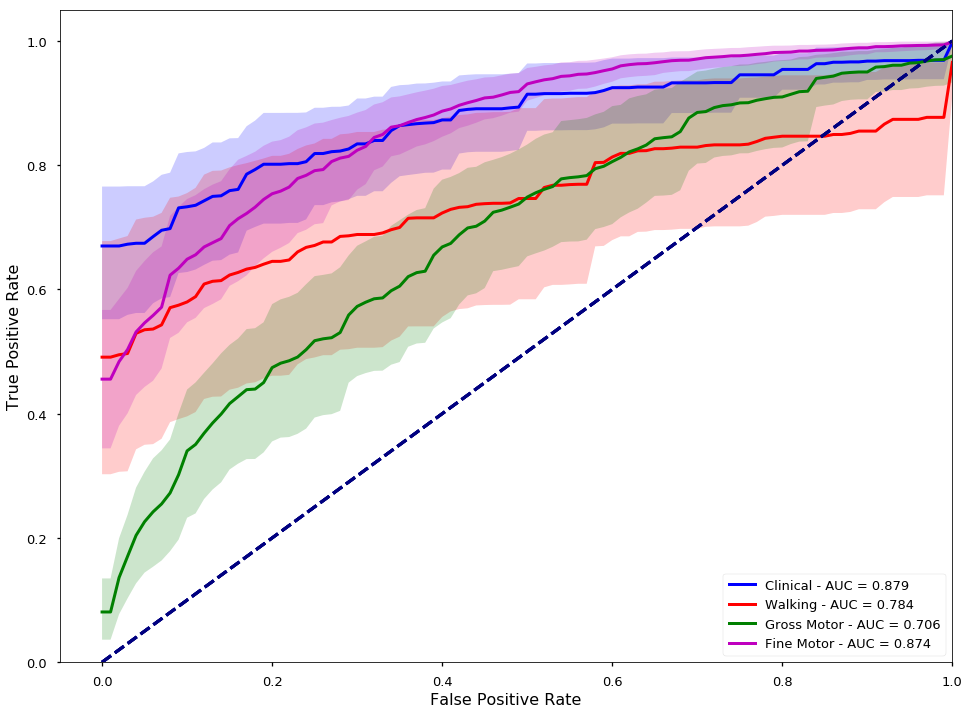

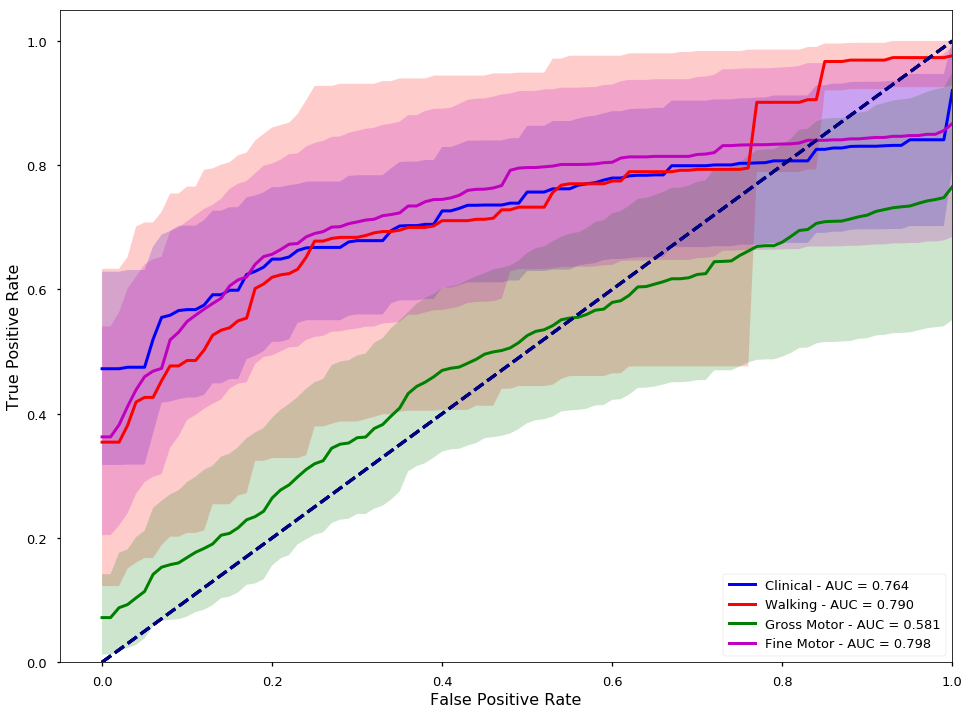

In [114]:
# Personal Models
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia', 'Tremor']:
    
    res_allvisits = {}
    for T in tasks:
        res_allvisits[tuple(T)] = {'tpr':[],'fpr':[],'auroc':[]}
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    for s in Data.Subject.unique():
        print('Subject %s'%s)
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,7:]
        X_std = StandardScaler().fit_transform(X) #standardize input data
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        

        models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
        model_name = ['Random Forest']
        models = list(zip(models,model_name))

        res,res_group = LOSOCV_Tasks(ds,X_std,y,groups,tasks,models[0][0])
        
        #loop through visits and remove NaNs
        for T in res_group.keys():
            NanInds = []
            for i in range(len(res_group[T]['auroc'])):
                if np.isnan(res_group[T]['auroc'][i]):
                    NanInds.append(i)
            for i in sorted(NanInds,reverse=True):
                del res_group[T]['tpr'][i]
                del res_group[T]['auroc'][i]
            if len(res_group[T]['auroc'])>0:
                res_allvisits[T]['tpr'].append(np.nanmean(res_group[T]['tpr'],axis=0))
                res_allvisits[T]['fpr'].append(np.nanmean(res_group[T]['fpr'],axis=0))
                res_allvisits[T]['auroc'].append(np.nanmean(res_group[T]['auroc']))
        
    Tasks = list(res_group.keys())
    AX=None
    plt.figure(figsize=(16,12))
    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor']
    for x,T in zip(range(len(Tasks)),Tasks):
        print(T)
        
        if AX==None:
            AX = plot_roc(res_allvisits[T]['tpr'],res_allvisits[T]['fpr'][0],np.mean(res_allvisits[T]['auroc']),
                          plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_allvisits[T]['tpr'],res_allvisits[T]['fpr'][0],np.mean(res_allvisits[T]['auroc']),
                     plotname=TaskNames[x],ax=AX,col=cols[x])

    plt.savefig(symptom+'PersonalTasks.svg')
    plt.savefig(symptom+'PersonalTasks.png')
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

# Effect of # of subjects

In [ ]:
# #if want to use only the selected features (to speed up)
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

### Bradykinesia

In [ ]:
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

In [ ]:
symptom

In [ ]:
#sample p subjects at random for train and test on 1 random remaining subject

results = pd.DataFrame()
subjs=Data.Subject.unique()
nsubj = [4,6,8,12,16] #of subjects to train on
clf = RandomForestClassifier(n_estimators=50,random_state=2)
auc_all={}
testsublist = []
t1=time.time()

for iteration in range(500):
    

    trainsubjall = np.random.choice(subjs,size=16,replace=False) #sample 16 subjects at random
    
    #pick a test subject at random
    losubjs = Data[~Data.Subject.isin(trainsubjall)].Subject.unique()
    testsubj = np.random.choice(losubjs)
    dtest = Data[Data.Subject==testsubj]
    testsublist.append(testsubj)
    
    #use top features
    Xte = dtest.iloc[:,7:].as_matrix()
#     Xte = dtest[topf].as_matrix()
    yte = (dtest[symptom]>0).values.astype(int)

    if iteration%10==0:
        print(iteration,trainsubjall,testsubj)

    #compute and store AUC for an incremental number of train subjects tested on the left out subject
    for NS in nsubj:
    
        trainsubj = trainsubjall[:NS] #add subjects incrementally each time
        dtrain = Data[Data.Subject.isin(trainsubj)]

        Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
#         Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)

        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auc_all.update({NS:auroc}) #store auc for each grp


    results=pd.concat((results,pd.DataFrame(auc_all,index=[iteration])))
    


#     results.update({ng:auc_all}) #save auc for all runs for each group
print('elapsed %.3f min'%((time.time()-t1)/60))


In [ ]:
results.to_csv('SimsMultiSubj_Brady.csv')

In [ ]:
np.save('SimsMultiSubj_testsublist_brady.npy',testsublist)

Bradykinesia Results

In [ ]:
results=pd.read_csv('SimsMultiSubj_Brady.csv',index_col=False)
results=results.drop('Unnamed: 0',axis=1)

In [ ]:
results2=results.iloc[:,1:].copy()

In [ ]:
baseline = results.iloc[:,0].copy()

In [ ]:
diffs = results2.apply(lambda x:x - baseline)

In [ ]:
diffs.plot(kind='box')

In [ ]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [ ]:
diffs['TestSubj']= testsublist

In [ ]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='6',data=diffs)

In [ ]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='16',data=diffs)

In [ ]:
a.shape

### Tremor Results

In [ ]:
results=pd.read_csv('SimsMultiSubj_Tremor.csv',index_col=False)

In [ ]:
results=results.drop('Unnamed: 0',axis=1)

In [ ]:
results=results.dropna()

In [ ]:
results2=results.iloc[:,1:].copy()

In [ ]:
baseline = results.iloc[:,0].copy()

In [ ]:
diffs = results2.apply(lambda x:x - baseline)

In [ ]:
diffs.plot(kind='box')

In [ ]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [ ]:
Xtr.shape

In [ ]:
# y=np.asarray(diffs)
# x = diffs.columns.values
# sns.tsplot(y,x,ci='sd')

## Personal models - Leave One visit out and LOin on Day 1 and Day 2

In [ ]:
Data.head(2)

Train on 1 session

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2

ax=plt.boxplot([day1_1.values, auroc2_1])
plt.title('Training on 1 session from Day 1')

    


Train on 5 sessions

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_5 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_5.append(auroc) #auc from each subject when tested on day 2

    
ax=plt.boxplot([day1_5.values, auroc2_5])
plt.title('Train on 5 Sessions from Day 1')

# Subgroup of tasks - Train and Test on subgroups of tasks (Just for reference, NOT USED in current version of the paper)

In [ ]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]

In [ ]:
results_task = pd.DataFrame(data=[]) #sae auc for each subject and set of tasks

for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on subtasks
    res_all = pd.DataFrame()
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Tremor']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=0)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        
        r = pd.DataFrame({i:res_group['Random Forest']['auroc']})
        results_task=pd.concat((results_task,r),axis=1)


results_task=results_task.rename(columns={0: "Structured", 1: "Walking", 2:'Gross',3:'Fine'})


In [ ]:
results_task

In [ ]:
results_task.plot(kind='box')
plt.title('Tremor')

In [ ]:
results_task.plot(kind='box')
plt.title('Tremor')